# Setting up the environment

In [ ]:
!git clone https://github.com/ultralytics/yolov5

!pip install -r yolov5/requirements.txt

# Importing required libraries

In [ ]:
import torch
from IPython.display import Image  
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# Downloading KITTI Dataset



In [ ]:
%mkdir KITTI_Dataset
%cd KITTI_Dataset

!wget -O kitti_annotations.zip https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip

!wget -O images.zip --limit-rate=30m https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip

/content/KITTI_Dataset
--2022-07-25 12:09:09--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.61
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5601213 (5.3M) [application/zip]
Saving to: ‘kitti_annotations.zip’

kitti_annotations.z 100%[===================>]   5.34M  3.27MB/s    in 1.6s    

2022-07-25 12:09:11 (3.27 MB/s) - ‘kitti_annotations.zip’ saved [5601213/5601213]

--2022-07-25 12:09:11--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.61
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12569945557 (12G) [application/zip]
Saving t

# Data Preprocessing

Annotations

In [ ]:
!unzip kitti_annotations.zip

shutil.move(r"/content/KITTI_Dataset/training/label_2",r"/content/KITTI_Dataset")

os.rename(r"label_2",r"kitti_annotations")

shutil.rmtree('/content/KITTI_Dataset/training')

!rm -r kitti_annotations.zip 

Images

In [ ]:
!unzip images.zip

shutil.move(r"/content/KITTI_Dataset/training/image_2",r"/content/KITTI_Dataset")

os.rename(r"image_2",r"images")

!rm -r training testing images.zip

# Converting KITTI Annotations to Pascal VOC XML Annotations

In [ ]:
%mkdir P_VOC_XML_annotations

import os
from xml.dom.minidom import Document
import cv2
def generate_xml(name,split_lines,img_size,class_ind):
    doc = Document()  #  establish DOM Document object 

    annotation = doc.createElement('annotation')
    doc.appendChild(annotation)

    title = doc.createElement('folder')
    title_text = doc.createTextNode('KITTI')
    title.appendChild(title_text)
    annotation.appendChild(title)

    img_name=name+'.png'   ## The format corresponding to your own data format , What I have here png

    title = doc.createElement('filename')
    title_text = doc.createTextNode(img_name)
    title.appendChild(title_text)
    annotation.appendChild(title)

    source = doc.createElement('source')
    annotation.appendChild(source)

    title = doc.createElement('database')
    title_text = doc.createTextNode('The KITTI Database')
    title.appendChild(title_text)
    source.appendChild(title)

    title = doc.createElement('annotation')
    title_text = doc.createTextNode('KITTI')
    title.appendChild(title_text)
    source.appendChild(title)

    size = doc.createElement('size')
    annotation.appendChild(size)

    title = doc.createElement('width')
    title_text = doc.createTextNode(str(img_size[1]))
    title.appendChild(title_text)
    size.appendChild(title)

    title = doc.createElement('height')
    title_text = doc.createTextNode(str(img_size[0]))
    title.appendChild(title_text)
    size.appendChild(title)

    title = doc.createElement('depth')
    title_text = doc.createTextNode(str(img_size[2]))
    title.appendChild(title_text)
    size.appendChild(title)

    for split_line in split_lines:
        line=split_line.strip().split()
        if line[0] in class_ind:
            object = doc.createElement('object')
            annotation.appendChild(object)

            title = doc.createElement('name')
            title_text = doc.createTextNode(line[0])
            title.appendChild(title_text)
            object.appendChild(title)

            title = doc.createElement('difficult')
            title_text = doc.createTextNode('0')
            title.appendChild(title_text)
            object.appendChild(title)

            bndbox = doc.createElement('bndbox')
            object.appendChild(bndbox)
            title = doc.createElement('xmin')
            title_text = doc.createTextNode(str(int(float(line[4]))))
            title.appendChild(title_text)
            bndbox.appendChild(title)
            title = doc.createElement('ymin')
            title_text = doc.createTextNode(str(int(float(line[5]))))
            title.appendChild(title_text)
            bndbox.appendChild(title)
            title = doc.createElement('xmax')
            title_text = doc.createTextNode(str(int(float(line[6]))))
            title.appendChild(title_text)
            bndbox.appendChild(title)
            title = doc.createElement('ymax')
            title_text = doc.createTextNode(str(int(float(line[7]))))
            title.appendChild(title_text)
            bndbox.appendChild(title)

    #  take DOM object doc write file 
    f = open('./P_VOC_XML_annotations/'+name+'.xml','w') # create a new xml file
    f.write(doc.toprettyxml(indent = ''))
    f.close()
# #source code
if __name__ == '__main__':
    class_ind=( 'Car', 'Truck', 'Tram', 'Van')  # Own category for example using only vehicles
    labels_dir='./kitti_annotations'   ## The path of your own label 
    for parent, dirnames, filenames in os.walk(labels_dir): #  Get the root directory respectively , Files in subdirectory and root directory 
        for file_name in filenames:
            full_path=os.path.join(parent, file_name) #  Get the full path of the file 
            f=open(full_path)
            split_lines = f.readlines()
            name= file_name[:-4] #  The last four digits are the extension .txt, Just take the front file name 
            img_name=name+'.png'
            img_path=os.path.join('./images',img_name) #  The path needs to be modified 
            print(img_path)
            img_size =cv2.imread(img_path).shape
            generate_xml(name,split_lines,img_size,class_ind)
print('all txts has converted into xmls')

# Testing the conversion

In [ ]:
!cat kitti_annotations/000047.txt
print('\n\nConverted to \n\n')
!cat P_VOC_XML_annotations/000047.xml

Car 0.00 0 -1.57 572.31 171.60 624.11 218.82 1.60 1.76 3.84 -0.38 1.13 26.54 -1.58
Car 0.43 0 -0.92 0.00 190.67 171.41 313.27 1.47 1.54 3.51 -8.37 1.59 10.68 -1.57
Car 0.00 0 -1.22 214.99 165.20 423.55 292.98 1.78 1.81 4.32 -4.65 1.49 12.25 -1.57
Car 0.00 1 -1.24 296.94 182.19 393.12 231.61 1.45 1.61 4.30 -8.54 1.37 23.68 -1.58
Car 0.00 0 -1.38 428.19 180.81 498.01 226.24 1.45 1.67 3.88 -5.00 1.30 25.13 -1.58
Van 0.00 1 -1.45 481.87 153.05 537.09 207.74 2.52 2.02 6.17 -4.88 1.02 36.41 -1.58
Car 0.00 1 -1.49 522.27 176.55 552.71 202.38 1.63 1.67 3.92 -4.64 1.07 47.70 -1.58
Car 0.04 1 -0.96 0.00 185.88 180.39 253.13 1.42 1.57 4.23 -12.64 1.46 17.75 -1.57
Car 0.00 2 -1.12 193.59 181.29 294.71 229.39 1.58 1.64 3.96 -12.99 1.45 25.90 -1.58


Converted to 


<?xml version="1.0" ?>
<annotation>
<folder>KITTI</folder>
<filename>000047.png</filename>
<source>
<database>The KITTI Database</database>
<annotation>KITTI</annotation>
</source>
<size>
<width>1241</width>
<height>376</height>
<depth>3

# Converting Pascal VOC XML Annotations to YOLOv5 TXT Annotaions 

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

print(extract_info_from_xml('P_VOC_XML_annotations/000047.xml'))

{'bboxes': [{'class': 'Car', 'xmin': 572, 'ymin': 171, 'xmax': 624, 'ymax': 218}, {'class': 'Car', 'xmin': 0, 'ymin': 190, 'xmax': 171, 'ymax': 313}, {'class': 'Car', 'xmin': 214, 'ymin': 165, 'xmax': 423, 'ymax': 292}, {'class': 'Car', 'xmin': 296, 'ymin': 182, 'xmax': 393, 'ymax': 231}, {'class': 'Car', 'xmin': 428, 'ymin': 180, 'xmax': 498, 'ymax': 226}, {'class': 'Van', 'xmin': 481, 'ymin': 153, 'xmax': 537, 'ymax': 207}, {'class': 'Car', 'xmin': 522, 'ymin': 176, 'xmax': 552, 'ymax': 202}, {'class': 'Car', 'xmin': 0, 'ymin': 185, 'xmax': 180, 'ymax': 253}, {'class': 'Car', 'xmin': 193, 'ymin': 181, 'xmax': 294, 'ymax': 229}], 'filename': '000047.png', 'image_size': (1241, 376, 3)}


In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Car": 0,
                           "Truck": 1,
                           "Tram": 2,
                           "Van": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("YOLOv5_annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
%mkdir YOLOv5_annotations

# Get the annotations
annotations = [os.path.join('P_VOC_XML_annotations', x) for x in os.listdir('P_VOC_XML_annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('YOLOv5_annotations', x) for x in os.listdir('YOLOv5_annotations') if x[-3:] == "txt"]

100%|██████████| 7481/7481 [00:01<00:00, 4507.83it/s]


# Testing the annotations

{0: 'Car', 1: 'Truck', 2: 'Tram', 3: 'Van'}
images/005458.png


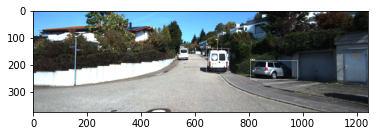

In [ ]:
random.seed(10)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
print(class_id_to_name_mapping)

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("YOLOv5_annotations", "images").replace("txt", "png")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


YOLOv5 expects the annotations to be located in a folder named labels

In [ ]:
os.rename(r"YOLOv5_annotations",r"labels")

!rm -r P_VOC_XML_annotations kitti_annotations

# Creating Train, Validation and Test Split

In [ ]:
# Read images and labels
images = [os.path.join('images', x) for x in os.listdir('images')]
labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2, random_state = 1)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size = 0.5, random_state = 1)


In [ ]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_labels, 'labels/train/')
move_files_to_folder(val_labels, 'labels/val/')
move_files_to_folder(test_labels, 'labels/test/')

# Creating Data Config File
> YOLOv5 needs the details of the dataset. Path of train, test and val images, the number of classes (nc) and name of each class. 

In [ ]:
f = open(r"/content/yolov5/data/data.yaml", 'w')
f.writelines(["train: /content/KITTI_Dataset/images/train ",
              "\nval: /content/KITTI_Dataset/images/val ",
              "\ntest: /content/KITTI_Dataset/images/test ",
              "\n\n# number of classes"
              "\nnc: 4 ",
              "\nnames: ['Car', 'Truck', 'Tram', 'Van'] # Class names "])
f.close()

In [ ]:
!cat ../yolov5/data/data.yaml

train: /content/KITTI_Dataset/images/train 
val: /content/KITTI_Dataset/images/val 
test: /content/KITTI_Dataset/images/test 

# number of classes
nc: 4 
names: ['Car', 'Truck', 'Tram', 'Van'] # Class names 

# Setup wandb for monitoring the training in real time and comparing diffrent versions of the model

In [ ]:
%cd ../yolov5 

!pip install wandb

In [ ]:
!wandb login <api_key>

# Training with default parameters to establish the baseline performance.
> epochs default is 300 changed to 25

In [ ]:
!python train.py --name Baseline_Model --epochs=25 --weights '' --cfg yolov5s.yaml --data data.yaml 

wandb: Currently logged in as: deshraja1. Use `wandb login --relogin` to force relogin
train: weights=, cfg=yolov5s.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Baseline_Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/Baseline_Model/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Running Inference on test images using Baseline Model


In [ ]:
!python detect.py --name Baseline_Model --data=data/data.yaml --source ../KITTI_Dataset/images/test/ --weights runs/train/Baseline_Model/weights/best.pt

detect: weights=['runs/train/Baseline_Model/weights/best.pt'], source=../KITTI_Dataset/images/test/, data=data/data.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=Baseline_Model, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/749 /content/KITTI_Dataset/images/test/000021.png: 224x640 6 Cars, 1 Van, Done. (0.015s)
image 2/749 /content/KITTI_Dataset/images/test/000034.png: 224x640 2 Cars, Done. (0.009s)
image 3/749 /content/KITTI_Dataset/images/test/000039.png: 224x640 5 Cars, Done. (0.010s)
image 4/749 /content/KITTI_Dataset/images/test/00004

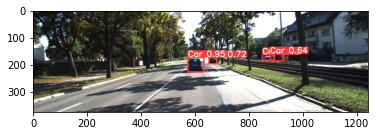

In [ ]:
detections_dir = "runs/detect/Baseline_Model/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# Validating Baseline Model

In [ ]:
!python val.py --name Baseline_Model --weights runs/train/Baseline_Model/weights/best.pt --data data.yaml

val: data=/content/yolov5/data/data.yaml, weights=['runs/train/Baseline_Model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=Baseline_Model, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/KITTI_Dataset/labels/val.cache' images and labels... 748 found, 0 missing, 79 empty, 0 corrupt: 100% 748/748 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 24/24 [00:14<00:00,  1.66it/s]
                 all        748       3380      0.833      0.839      0.892      0.569
                 Car        748       2919      0.898      0.831      0.918   

# Testing Baseline Model

In [ ]:
!python val.py --task test --name Baseline_Model --weights runs/train/Baseline_Model/weights/best.pt --data data.yaml 

val: data=/content/yolov5/data/data.yaml, weights=['runs/train/Baseline_Model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=Baseline_Model, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/KITTI_Dataset/labels/test' images and labels...749 found, 0 missing, 66 empty, 0 corrupt: 100% 749/749 [00:01<00:00, 381.83it/s]
test: New cache created: /content/KITTI_Dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 24/24 [00:14<00:00,  1.70it/s]
                 all        749       3298       0.85      0.777       0.88      0.554
       

# Model v2
> epoch same as baseline model = 25
>> image size default is 640 changed to 1280

In [ ]:
!python train.py --name Modelv2 --imgsz=1280 --epochs=25 --weights '' --cfg yolov5s.yaml --data data.yaml 

wandb: Currently logged in as: deshraja1. Use `wandb login --relogin` to force relogin
train: weights=, cfg=yolov5s.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Modelv2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 34 (delta 20), reused 24 (delta 12), pack-reused 0
Unpacking objects: 100% (34/34), done.
From https://github.com/ultralytics/yolov5
   7215a0f..a6f197a  master     -> origi

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/Modelv2/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Running Inference on test images using Modelv2


In [ ]:
!python detect.py --name Modelv2 --imgsz=1280 --data=data/data.yaml --source ../KITTI_Dataset/images/test/ --weights runs/train/Modelv2/weights/best.pt

detect: weights=['runs/train/Modelv2/weights/best.pt'], source=../KITTI_Dataset/images/test/, data=data/data.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=Modelv2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/749 /content/KITTI_Dataset/images/test/000021.png: 416x1280 6 Cars, 1 Van, Done. (0.015s)
image 2/749 /content/KITTI_Dataset/images/test/000034.png: 416x1280 2 Cars, Done. (0.015s)
image 3/749 /content/KITTI_Dataset/images/test/000039.png: 416x1280 5 Cars, Done. (0.015s)
image 4/749 /content/KITTI_Dataset/images/test/000044.png: 41

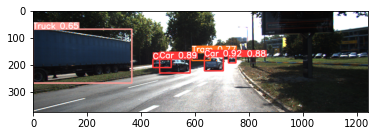

In [ ]:
detections_dir = "runs/detect/Modelv2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# Validating Modelv2

In [ ]:
!python val.py --name Modelv2 --imgsz=1280 --weights runs/train/Modelv2/weights/best.pt --data data.yaml

val: data=/content/yolov5/data/data.yaml, weights=['runs/train/Modelv2/weights/best.pt'], batch_size=32, imgsz=1280, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=Modelv2, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/KITTI_Dataset/labels/val.cache' images and labels... 748 found, 0 missing, 79 empty, 0 corrupt: 100% 748/748 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 24/24 [00:16<00:00,  1.44it/s]
                 all        748       3380      0.899      0.875      0.941      0.691
                 Car        748       2919      0.933      0.889       0.96      0.728
    

# Testing Modelv2

In [ ]:
!python val.py --task test --name Modelv2 --imgsz=1280 --weights runs/train/Modelv2/weights/best.pt --data data.yaml 

val: data=/content/yolov5/data/data.yaml, weights=['runs/train/Modelv2/weights/best.pt'], batch_size=32, imgsz=1280, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=Modelv2, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-318-g7215a0f Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/KITTI_Dataset/labels/test.cache' images and labels... 749 found, 0 missing, 66 empty, 0 corrupt: 100% 749/749 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 24/24 [00:16<00:00,  1.46it/s]
                 all        749       3298      0.918      0.859       0.94      0.671
                 Car        749       2845      0.941      0.891      0.962      0.734
 

# Model v3
> epoch same as baseline model and model v2 = 25
>> image size same as model v2 i.e 1280 but diffrent from baseline model i.e 640
>>> hyp default is hyp.scratch-low.yaml changed to hyp.scratch-high.yaml
>>>> instead of using no weights and starting training from scratch used yolov5s.pt pre trained model weight

In [ ]:
!python train.py --name Modelv3 --hyp hyp.scratch-high.yaml --imgsz=1280 --epochs=25 --weights 'yolov5s.pt' --cfg yolov5s.yaml --data data.yaml 

wandb: Currently logged in as: deshraja1. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=hyp.scratch-high.yaml, epochs=25, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Modelv3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (7/7), done.
remote: Total 8 (delta 6), reused 7 (delta 6), pack-reused 1
Unpacking objects: 100% (8/8), done.
From https://github.com/ultralytics/yolov5
   a6f197a..b367860  master     -> origin/master
   9db31ea..0551a31  classifier -> origin/classi

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/Modelv3/weights/best.pt')

# Running Inference on test images using Modelv3


In [ ]:
!python detect.py --name Modelv3 --imgsz=1280 --data=data/data.yaml --source ../KITTI_Dataset/images/test/ --weights runs/train/Modelv3/weights/best.pt

In [ ]:
detections_dir = "runs/detect/Modelv3/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# Validating Modelv3

In [ ]:
!python val.py --name Modelv3 --imgsz=1280 --weights runs/train/Modelv3/weights/best.pt --data data.yaml

# Testing Modelv3

In [ ]:
!python val.py --task test --name Modelv3 --imgsz=1280 --weights runs/train/Modelv3/weights/best.pt --data data.yaml 